In [ ]:
!pip install "gluonts[torch]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 28.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64

In [64]:
!pip install "gluonts[mxnet]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.23.5 which is incompatible.


In [ ]:
!pip install ucimlrepo

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)


In [83]:
df = air_quality.data.features.copy()
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Set 'Datetime' as the index
df.set_index('Datetime', inplace=True)

# Optionally, you can drop the original 'Date' and 'Time' columns if they are no longer needed
df.drop(columns=['Date', 'Time'], inplace=True)
df = df[['CO(GT)']]
df = df.rename({'CO(GT)':'CO'}, axis=1)
df[df['CO'] == -200] = np.nan

In [84]:
df.interpolate(method = 'linear', inplace=True)

In [85]:
df.index.max()

Timestamp('2005-04-04 14:00:00')

In [7]:
df = df[['CO']] * 1000
df.CO = np.floor(df.CO)

In [86]:
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (20, 3)

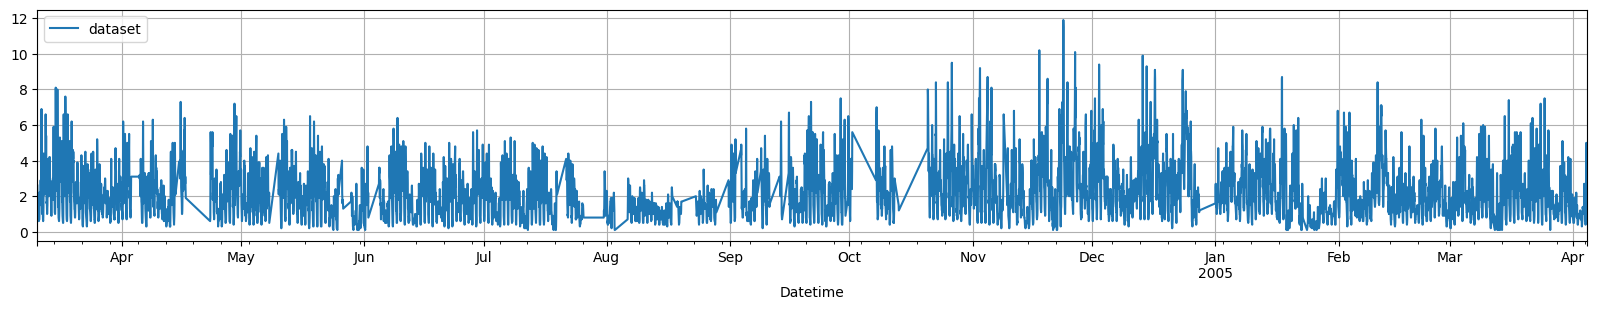

In [87]:
df.plot()
plt.legend(["dataset"], loc="upper left")
plt.show()

In [88]:
dataset = PandasDataset(df, target="CO")

In [89]:
from gluonts.dataset.util import to_pandas


def highlight_entry(entry, color):
    start = entry["start"]
    end = entry["start"] + len(entry["target"])
    plt.axvspan(start, end, facecolor=color, alpha=0.2)


def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(original_dataset, training_dataset):
        to_pandas(original_entry).plot()
        highlight_entry(train_entry, "red")
        plt.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in original_dataset:
        for test_input, test_label in test_pairs:
            to_pandas(original_entry).plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()

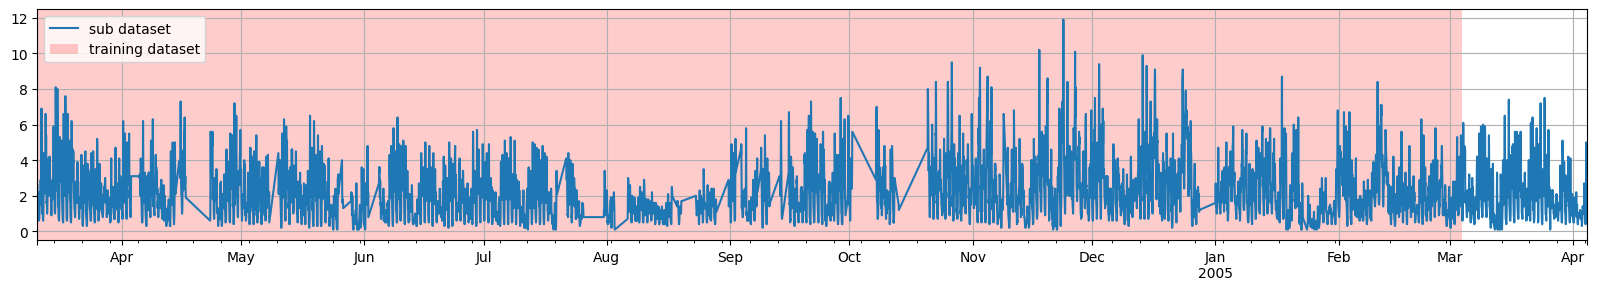

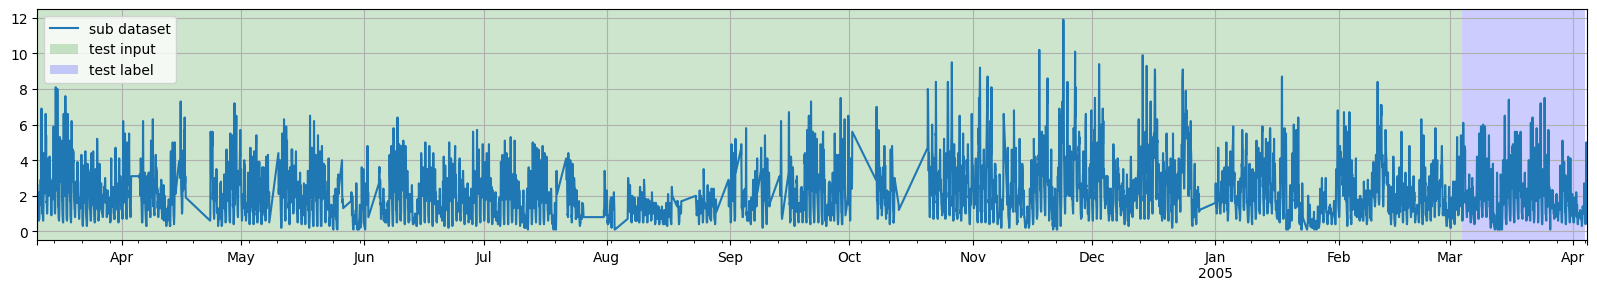

In [90]:
prediction_length = 24*31
training_dataset, test_template = split(
    dataset, date=pd.Period("2005-03-04 00:00:00", freq="1H")
)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=1,
)

plot_dataset_splitting(dataset, training_dataset, test_pairs)

In [100]:
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from gluonts.torch import DeepAREstimator

model = DeepAREstimator(
    prediction_length=24*31, freq="h", trainer_kwargs={"max_epochs": 20}
).train(training_dataset)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | In sizes                                                          | Out sizes    
-------------------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 1.71139 (best 1.71139), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 1.71139 (best 1.71139), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 1.11921 (best 1.11921), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 1.11921 (best 1.11921), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 0.78009 (best 0.78009), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1

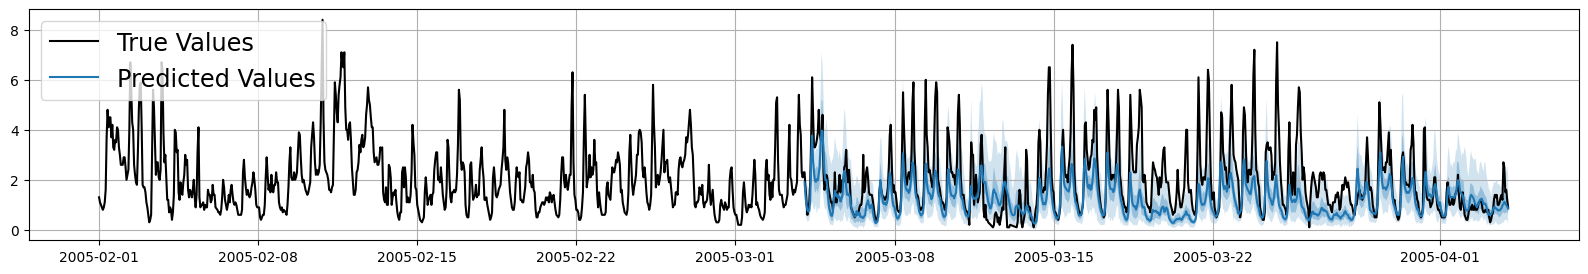

In [106]:
forecasts = list(model.predict(test_pairs.input))

start_date = pd.Timestamp('2005-03-04 01:00')
end_date = start_date + pd.DateOffset(hours=forecasts[0].prediction_length-1)
# Plot predictions
plt.plot(df["2005-02":end_date], color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True Values", "Predicted Values"], loc="upper left", fontsize="xx-large")
plt.show()

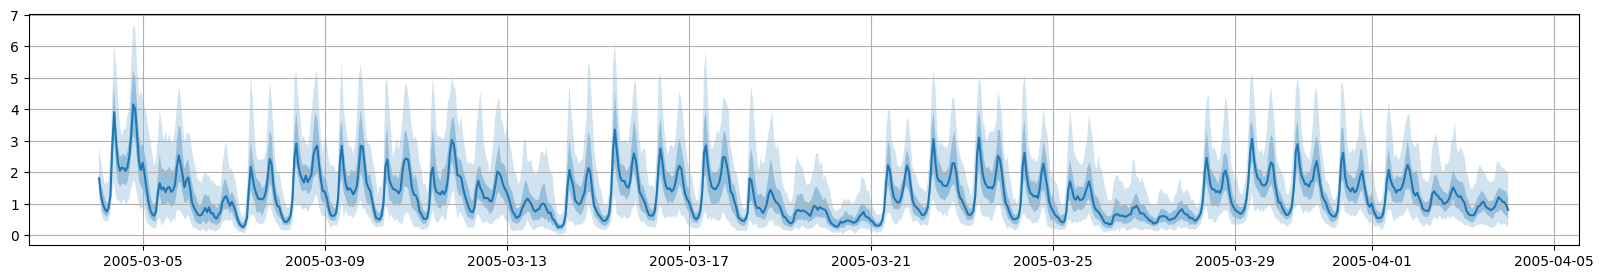

In [102]:
for forecast in forecasts:
  forecast.plot()

In [103]:
def evaluate_model(true_values, predicted_values, num_params):
    # Calculate MAE
    mae = np.mean(np.abs(true_values - predicted_values))

    # Calculate RMSE
    rmse = np.sqrt(np.mean((true_values - predicted_values) ** 2))

    # Calculate AICc
    n = len(true_values)  # Number of data points
    rss = np.sum((true_values - predicted_values) ** 2)  # Residual sum of squares
    aic = n * np.log(rss / n) + 2 * num_params
    aicc = aic + (2 * num_params * (num_params + 1)) / (n - num_params - 1)

    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"AICc: {aicc}")

# Extract true values from the original dataset for the prediction period
# notice that we scale the data back here
start_date = pd.Timestamp('2005-03-04 01:00')
end_date = start_date + pd.DateOffset(hours=forecasts[0].prediction_length-1)
true_values = df[start_date:end_date]["CO"].values/1000

# Extract predicted values
predicted_values = np.concatenate([forecast.mean for forecast in forecasts], axis=0)/1000

# Number of parameters in the model
num_params = sum(p.numel() for p in model.network.parameters())

# Evaluate the model
evaluate_model(true_values, predicted_values, num_params)




MAE: 0.0008196069618889195
RMSE: 0.0011746083154743972
AICc: -11568.367205946946
